# ELEN 6885 Reinforcement Learning Coding Assignment (Part 4) #
There are a lot of official and unofficial tutorials about Tensorflow, and there are also many open-source projects written in Tensorflow. You can refer to those resources according to your interest. In this part of homework 4, only knowledge of Deep Reinforcement Learning and basic programming skills will be needed.

Please put your code into the block marked by\
\############################\
\# YOUR CODE STARTS HERE\
\# YOUR CODE ENDS HERE\
\############################\
Normally you don't need to edit anything outside of the block. If you do want to edit something, please use a similar manner to mark you edits.


In [1]:
import numpy as np
import tensorflow as tf

# DQN
class DQN:
  def __init__(
      self,
      actions_num,
      state_size,
      learning_rate = 0.001,
      gamma = 0.99,
      epsilon_min = 0.05,
      epsilon_start = 0.9,
      replace_target_iter = 300,
      memory_size = 500,
      batch_size = 2,
      epsilon_increment = None,
  ):
      self.actions_num = actions_num
      self.state_size = state_size
      self.lr = learning_rate
      self.gamma = gamma
      self.epsilon_min = epsilon_min
      self.replace_target_iter = replace_target_iter
      self.memory_size = memory_size
      self.batch_size = batch_size
      self.epsilon_increment = epsilon_increment
      self.epsilon = epsilon_start if epsilon_increment is not None else self.epsilon_min
      self.save_model_path = './weights/DQN_model.ckpt'
      self.memory_counter = 0

      # learned steps counter
      self.steps_counter = 0

      # initialize memory [s, a, r, s_, done]
      self.memory = np.zeros((self.memory_size, state_size * 2 + 3))

      # build target_net and q_net
      self.build_net()
      t_params = tf.get_collection('target_net_params')
      q_params = tf.get_collection('q_net_params')
      self.replace_target = [tf.assign(t, q) for t, q in zip(t_params, q_params)]

      # gpu setting
      config = tf.ConfigProto(log_device_placement=False, allow_soft_placement=True)
      config.gpu_options.per_process_gpu_memory_fraction = 0.6
      self.sess = tf.Session(config=config)

      self.sess.run(tf.global_variables_initializer())

  def build_net(self):
    # build q_net
    self.state = tf.placeholder(tf.float32, [None, self.state_size], name='state')
    self.q_target = tf.placeholder(tf.float32, [None, self.actions_num], name='Q_target')
    with tf.variable_scope('q_net'):
      # c_names(collections_names) are the collections to store variables
      c_names, neurons_layer_1, w_initializer, b_initializer = \
        ['q_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 100, \
        tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)

      # layer 1
      with tf.variable_scope('layer_1'):
        w_layer_1 = tf.get_variable('w_layer_1', [self.state_size, neurons_layer_1], initializer=w_initializer, collections=c_names)
        b_layer_1 = tf.get_variable('b_layer_1', [1, neurons_layer_1], initializer=b_initializer, collections=c_names)
        layer_1 = tf.nn.relu(tf.matmul(self.state, w_layer_1) + b_layer_1)

      # layer 2
      with tf.variable_scope('layer_2'):
        w_layer_2 = tf.get_variable('w_layer_2', [neurons_layer_1, self.actions_num], initializer=w_initializer, collections=c_names)
        b_layer_2 = tf.get_variable('b_layer_2', [1, self.actions_num], initializer=b_initializer, collections=c_names)
        self.q_value = tf.matmul(layer_1, w_layer_2) + b_layer_2

    with tf.variable_scope('loss'):
      self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_value))
    with tf.variable_scope('train'):
      self._train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss)

    # build target_net
    self.state_t = tf.placeholder(tf.float32, [None, self.state_size], name='state_t')    # input
    with tf.variable_scope('target_net'):
      # c_names(collections_names) are the collections to store variables
      c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

      # layer 1
      with tf.variable_scope('layer_1'):
        w_layer_1 = tf.get_variable('w_layer_1', [self.state_size, neurons_layer_1], initializer=w_initializer, collections=c_names)
        b_layer_1 = tf.get_variable('b_layer_1', [1, neurons_layer_1], initializer=b_initializer, collections=c_names)
        layer_1 = tf.nn.relu(tf.matmul(self.state_t, w_layer_1) + b_layer_1)
        
      with tf.variable_scope('layer_2'):
        w_layer_2 = tf.get_variable('w_layer_2', [neurons_layer_1, self.actions_num], initializer=w_initializer, collections=c_names)
        b_layer_2 = tf.get_variable('b_layer_2', [1, self.actions_num], initializer=b_initializer, collections=c_names)
        self.q_next = tf.matmul(layer_1, w_layer_2) + b_layer_2  


  def store_transition(self, s, a, r, s_, done):
    s=s.reshape(-1)
    s_=s_.reshape(-1)
    transition = np.hstack((s, [a, r], s_, done))

    # replace the old memory with new observations
    index = self.memory_counter % self.memory_size
    self.memory[index, :] = transition

    self.memory_counter += 1

  def choose_action(self, observation):
    # to have batch dimension when fed into tf placeholder
    observation = observation[np.newaxis, :]
    # epsilon-greedy
    if np.random.uniform() > self.epsilon:
      action_values = self.sess.run(self.q_value, feed_dict={self.state: observation})
      action = np.argmax(action_values)
    else:
      action = np.random.randint(0, self.actions_num)
    return action

  def learn(self):
    # replace target parameters every once a while
    if self.steps_counter % self.replace_target_iter == 0:
      self.sess.run(self.replace_target)

    # sample a batch from the memory
    if self.memory_counter > self.memory_size:
      sample_index = np.random.choice(self.memory_size, size=self.batch_size)
    else:
      sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
    batch_memory = self.memory[sample_index, :]

    q_next, q_value = self.sess.run(
      [self.q_next, self.q_value],
      feed_dict={
        self.state_t: batch_memory[:, -self.state_size-1:-1],  # fixed params
        self.state: batch_memory[:, :self.state_size],  # newest params
      })

    # calculate q_target
    q_target = q_value.copy()

    # only change the action-values of this batch, because we only calculate loss on the batch observations
    batch_index = np.arange(self.batch_size, dtype=np.int32)
    act_index = batch_memory[:, self.state_size].astype(int)
    reward = batch_memory[:, self.state_size + 1]
    done = batch_memory[:, -1]
    ############################
    # YOUR CODE STARTS HERE
    q_target[batch_index, act_index] = reward + self.gamma * q_next.max(axis = 1) * np.logical_not(done)
    
    # YOUR CODE ENDS HERE
    ############################
    
    # train q_net
    _, self.cost = self.sess.run([self._train_op, self.loss],
                                  feed_dict={self.state: batch_memory[:, :self.state_size],
                                            self.q_target: q_target})
    # change epsilon
    self.epsilon = self.epsilon - self.epsilon_increment if self.epsilon > self.epsilon_min else self.epsilon_min
    self.steps_counter += 1

  def store(self):
    saver = tf.train.Saver() 
    saver.save(self.sess, self.save_model_path)
  
  def restore(self):
    saver = tf.train.Saver() 
    saver.restore(self.sess, self.save_model_path)






In [2]:
import gym
# cart pole gym environment
env = gym.make("CartPole-v0")
env._max_episode_steps = 500
# state and action space
print(env.action_space)
print(env.observation_space)
# observation
env.reset()
# state, reward, done, info
print(env.step(1))

Discrete(2)
Box(4,)
(array([-0.03001625,  0.15348578,  0.02918976, -0.29231052]), 1.0, False, {})


In [ ]:
# play the game and train the network
#from tqdm import tqdm
from matplotlib import pyplot as plt

np.set_printoptions(threshold=np.inf)
episode_length_set = []
tf.reset_default_graph()
total_time_steps =  100000

RL = DQN(actions_num = 2, gamma = 0.99,
         state_size = 4, epsilon_start = 1,
         learning_rate = 1e-3, epsilon_min = 0.01,
         replace_target_iter = 100, memory_size = 5000,
         epsilon_increment = 0.00001,)


done = False
episode_length_counter = 0
state = env.reset()
for step in range(total_time_steps):
  ############################
  # YOUR CODE STARTS HERE
      
  action = RL.choose_action(state)
  next_state, reward, done, info = env.step(action)
  RL.store_transition(state, action, reward, next_state, done)
  
  if done:
    episode_length_set.append(episode_length_counter)
    episode_length_counter = 0
    state = env.reset()
  else:
    state = next_state

  # YOUR CODE ENDS HERE
  ############################
  
  if step > 200:
    RL.learn()
  episode_length_counter += 1
  if episode_length_counter == 500:
    print("Reached 500 steps")
    RL.store()

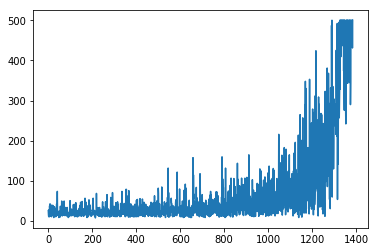

In [4]:
from matplotlib import pyplot as plt
plt.plot(episode_length_set)
plt.show()

In [6]:
# test our network
tf.reset_default_graph()
RL = DQN(actions_num = 2, gamma = 1,
         state_size = 4, epsilon_start = 1,
         learning_rate = 1e-3, epsilon_min = 0,
         replace_target_iter = 100, memory_size = 5000,
         epsilon_increment = None,)
# load saved parameters
RL.restore()
# run 100 trails and print how long can the agent hold the cart pole for each trail
for i in range(100):
  ############################
  # YOUR CODE STARTS HERE
  state = env.reset()
  done = False
  step = 0
  
  while not done:
    action_values = RL.sess.run(RL.q_value, feed_dict = {RL.state : state[np.newaxis, :]})
    action = RL.choose_action(state)
    next_state, reward, done, info = env.step(action)
    step += 1
    state = next_state
    
    if done: 
      state = env.reset()
      print("Episode: {} No. of steps balanced: {}".format(i, step))
      step = 0
  # YOUR CODE ENDS HERE
  ############################
  

INFO:tensorflow:Restoring parameters from ./weights/DQN_model.ckpt
Episode: 0 No. of steps balanced: 494
Episode: 1 No. of steps balanced: 500
Episode: 2 No. of steps balanced: 489
Episode: 3 No. of steps balanced: 500
Episode: 4 No. of steps balanced: 500
Episode: 5 No. of steps balanced: 499
Episode: 6 No. of steps balanced: 500
Episode: 7 No. of steps balanced: 486
Episode: 8 No. of steps balanced: 496
Episode: 9 No. of steps balanced: 487
Episode: 10 No. of steps balanced: 500
Episode: 11 No. of steps balanced: 499
Episode: 12 No. of steps balanced: 500
Episode: 13 No. of steps balanced: 500
Episode: 14 No. of steps balanced: 498
Episode: 15 No. of steps balanced: 500
Episode: 16 No. of steps balanced: 500
Episode: 17 No. of steps balanced: 500
Episode: 18 No. of steps balanced: 500
Episode: 19 No. of steps balanced: 500
Episode: 20 No. of steps balanced: 500
Episode: 21 No. of steps balanced: 500
Episode: 22 No. of steps balanced: 499
Episode: 23 No. of steps balanced: 497
Episode

You may find that the episode length doesn't stably improve as more training time is given. You can read chapter 3.2 of this paper https://arxiv.org/pdf/1711.07478.pdf if you are interested.